In [1]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

Using TensorFlow backend.


In [2]:
maxlen=0
word_freqs = collections.Counter()
num_recs=0

In [3]:
with open("training.txt", encoding="utf8") as ftrain:
    for line in ftrain:
        label, sentence = line.strip().split("\t")
        #print(label)
        #print(sentence)
        words = nltk.word_tokenize(sentence.lower())
        #print(words)
        maxlen = max(maxlen, len(words))
        for word in words:
            word_freqs[word]+=1
        num_recs+=1

In [4]:
maxlen

42

In [5]:
len(word_freqs)

2328

In [6]:
num_recs

7086

In [7]:
word_freqs

Counter({'the': 3221,
         'da': 1998,
         'vinci': 2001,
         'code': 1986,
         'book': 133,
         'is': 1521,
         'just': 287,
         'awesome': 1028,
         '.': 3558,
         'this': 213,
         'was': 1179,
         'first': 104,
         'clive': 1,
         'cussler': 1,
         'i': 4705,
         "'ve": 11,
         'ever': 96,
         'read': 113,
         ',': 4194,
         'but': 295,
         'even': 27,
         'books': 25,
         'like': 974,
         'relic': 1,
         'and': 2150,
         'were': 96,
         'more': 102,
         'plausible': 1,
         'than': 14,
         'liked': 101,
         'a': 1305,
         'lot': 21,
         'it': 897,
         'ultimatly': 1,
         'did': 33,
         "n't": 223,
         'seem': 1,
         'to': 808,
         'hold': 2,
         "'s": 629,
         'own': 4,
         'that': 718,
         'not': 198,
         'an': 225,
         'exaggeration': 1,
         ')': 44,
         '

## 设定词汇表的大小为：2330
### 对于不在词汇表中的单词，统一用UNK替换。

## 最长句子为42.
### 序列长度可以固定为42. 对于较短的句子，使用zero来填充。对于较长的句子，可以截断处理。

## 因此，设定词汇表大小为2002.
### 也就是，2000单词，加上未知词UNK和填充词PAD。

## 设定序列长度为40.

In [8]:
MAX_FEATURES=2000
MAX_SENTENCE_LENGTH=40

In [9]:
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2

word2index = {x[0]:(i+2) for i,x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"]=0
word2index["UNK"]=1

index2word={v:k for k,v in word2index.items()}

In [10]:
vocab_size

2002

In [11]:
word2index

{'i': 2,
 ',': 3,
 '.': 4,
 'the': 5,
 'and': 6,
 '!': 7,
 'harry': 8,
 'vinci': 9,
 'da': 10,
 'brokeback': 11,
 'code': 12,
 'mountain': 13,
 'potter': 14,
 '...': 15,
 'love': 16,
 'is': 17,
 'a': 18,
 'was': 19,
 'mission': 20,
 'impossible': 21,
 'awesome': 22,
 'like': 23,
 'it': 24,
 'to': 25,
 'movie': 26,
 'that': 27,
 "'s": 28,
 'because': 29,
 'sucks': 30,
 'hate': 31,
 'sucked': 32,
 'so': 33,
 'as': 34,
 'my': 35,
 '``': 36,
 'much': 37,
 'of': 38,
 'really': 39,
 'movies': 40,
 'stupid': 41,
 'you': 42,
 'down': 43,
 'but': 44,
 'we': 45,
 'be': 46,
 'with': 47,
 'just': 48,
 'one': 49,
 'know': 50,
 'potter..': 51,
 'suck': 52,
 'out': 53,
 '3': 54,
 'who': 55,
 '/': 56,
 'or': 57,
 'am': 58,
 'loved': 59,
 'want': 60,
 'into': 61,
 'which': 62,
 'right': 63,
 'for': 64,
 'an': 65,
 "n't": 66,
 'this': 67,
 'me': 68,
 ':': 69,
 'are': 70,
 'think': 71,
 'not': 72,
 'how': 73,
 'if': 74,
 'depressing': 75,
 'people': 76,
 'his': 77,
 'would': 78,
 'up': 79,
 'reading': 80

In [12]:
index2word

{2: 'i',
 3: ',',
 4: '.',
 5: 'the',
 6: 'and',
 7: '!',
 8: 'harry',
 9: 'vinci',
 10: 'da',
 11: 'brokeback',
 12: 'code',
 13: 'mountain',
 14: 'potter',
 15: '...',
 16: 'love',
 17: 'is',
 18: 'a',
 19: 'was',
 20: 'mission',
 21: 'impossible',
 22: 'awesome',
 23: 'like',
 24: 'it',
 25: 'to',
 26: 'movie',
 27: 'that',
 28: "'s",
 29: 'because',
 30: 'sucks',
 31: 'hate',
 32: 'sucked',
 33: 'so',
 34: 'as',
 35: 'my',
 36: '``',
 37: 'much',
 38: 'of',
 39: 'really',
 40: 'movies',
 41: 'stupid',
 42: 'you',
 43: 'down',
 44: 'but',
 45: 'we',
 46: 'be',
 47: 'with',
 48: 'just',
 49: 'one',
 50: 'know',
 51: 'potter..',
 52: 'suck',
 53: 'out',
 54: '3',
 55: 'who',
 56: '/',
 57: 'or',
 58: 'am',
 59: 'loved',
 60: 'want',
 61: 'into',
 62: 'which',
 63: 'right',
 64: 'for',
 65: 'an',
 66: "n't",
 67: 'this',
 68: 'me',
 69: ':',
 70: 'are',
 71: 'think',
 72: 'not',
 73: 'how',
 74: 'if',
 75: 'depressing',
 76: 'people',
 77: 'his',
 78: 'would',
 79: 'up',
 80: 'reading'

## 对评论进行编码为数字

In [13]:
# 输入序列的长度，暂不指定
X = []
y = []

with open("training.txt", encoding="utf8") as ftrain:
    for line in ftrain:
        label, sentence = line.strip().split("\t")
        words = nltk.word_tokenize(sentence.lower())
        seqs=[]
        for word in words:
            if word in word2index:
                seqs.append(word2index[word])
            else:
                seqs.append(word2index["UNK"])
        X.append(seqs)
        y.append(int(label))
X = np.array(X)
y = np.array(y)

In [14]:
X[:10]

array([list([5, 10, 9, 12, 101, 17, 48, 22, 4]),
       list([67, 19, 5, 115, 969, 970, 2, 358, 136, 110, 3, 44, 317, 319, 23, 971, 3, 6, 10, 9, 12, 137, 118, 972, 341, 67, 4]),
       list([2, 122, 5, 10, 9, 12, 18, 325, 4]),
       list([2, 122, 5, 10, 9, 12, 18, 325, 4]),
       list([2, 122, 5, 10, 9, 12, 44, 24, 973, 313, 66, 974, 25, 648, 24, 28, 485, 4]),
       list([27, 28, 72, 317, 65, 975, 308, 6, 111, 976, 45, 108, 25, 977, 25, 649, 5, 10, 9, 12, 3, 62, 17, 338, 38, 399, 4]),
       list([2, 59, 5, 10, 9, 12, 3, 44, 326, 2, 60, 400, 143, 6, 486, 7, 92]),
       list([2, 119, 10, 9, 12, 19, 142, 3, 162, 47, 978, 979, 4]),
       list([5, 10, 9, 12, 17, 342, 18, 104, 26, 15]),
       list([2, 119, 5, 10, 9, 12, 19, 18, 314, 104, 101, 4])], dtype=object)

In [15]:
# 填充短的句子
# 或 截断长的句子
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)

In [16]:
help(sequence.pad_sequences)

Help on function pad_sequences in module keras.preprocessing.sequence:

pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)
    Pads each sequence to the same length (length of the longest sequence).
    
    If maxlen is provided, any sequence longer
    than maxlen is truncated to maxlen.
    Truncation happens off either the beginning (default) or
    the end of the sequence.
    
    Supports post-padding and pre-padding (default).
    
    # Arguments
        sequences: list of lists where each element is a sequence
        maxlen: int, maximum length
        dtype: type to cast the resulting sequence.
        padding: 'pre' or 'post', pad either before or after each sequence.
        truncating: 'pre' or 'post', remove values from sequences larger than
            maxlen either in the beginning or in the end of the sequence
        value: float, value to pad the sequences to the desired value.
    
    # Returns
        x: numpy array 

In [17]:
X[:10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   5,  10,   9,  12, 101,  17,  48,  22,
          4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         67,  19,   5, 115, 969, 970,   2, 358, 136, 110,   3,  44, 317,
        319,  23, 971,   3,   6,  10,   9,  12, 137, 118, 972, 341,  67,
          4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2, 122,   5,  10,   9,  12,  18, 325,
          4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2, 122,   5,  10,   9,  12,  18, 325,
          4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 

## 训练和测试数据集的划分

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=666)

In [19]:
len(X)

7086

In [20]:
len(Xtrain)

5668

In [21]:
len(Xtest)

1418

## 网络结构

### 输入输出
1. 输入是（None, MAX_SEQUENCE_LENGTH, 1），None表示是batch_size，暂时还未指定，在运行时根据传入数据指定。
2. 经过embedding layer，输出（None, MAX_SENTENCE_LENGTH, EMBEDDING_SIZE）
3. 经过LSTM，输出（None, HIDDEN_LAYER_SIZE, MAX_SENTENCE_LENGTH）。注意，默认情况下，LSTM会在最后序列输出单一tensor（大小为：（None, HIDDEN_LAYER_SIZE））。
4. 输出层，sigmoid激活函数。

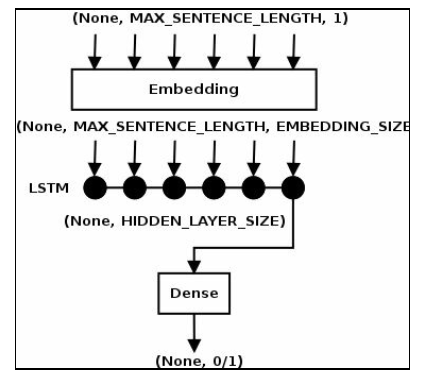

## 超参数

In [22]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [23]:
help(Embedding)

Help on class Embedding in module keras.layers.embeddings:

class Embedding(keras.engine.topology.Layer)
 |  Turns positive integers (indexes) into dense vectors of fixed size.
 |  eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
 |  
 |  This layer can only be used as the first layer in a model.
 |  
 |  # Example
 |  
 |  ```python
 |    model = Sequential()
 |    model.add(Embedding(1000, 64, input_length=10))
 |    # the model will take as input an integer matrix of size (batch, input_length).
 |    # the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
 |    # now model.output_shape == (None, 10, 64), where None is the batch dimension.
 |  
 |    input_array = np.random.randint(1000, size=(32, 10))
 |  
 |    model.compile('rmsprop', 'mse')
 |    output_array = model.predict(input_array)
 |    assert output_array.shape == (32, 10, 64)
 |  ```
 |  
 |  # Arguments
 |    input_dim: int > 0. Size of the vocabulary,
 |        i.e. maximum int

In [24]:
help(LSTM)

Help on class LSTM in module keras.layers.recurrent:

class LSTM(RNN)
 |  Long-Short Term Memory layer - Hochreiter 1997.
 |  
 |  # Arguments
 |      units: Positive integer, dimensionality of the output space.
 |      activation: Activation function to use
 |          (see [activations](../activations.md)).
 |          If you pass None, no activation is applied
 |          (ie. "linear" activation: `a(x) = x`).
 |      recurrent_activation: Activation function to use
 |          for the recurrent step
 |          (see [activations](../activations.md)).
 |      use_bias: Boolean, whether the layer uses a bias vector.
 |      kernel_initializer: Initializer for the `kernel` weights matrix,
 |          used for the linear transformation of the inputs.
 |          (see [initializers](../initializers.md)).
 |      recurrent_initializer: Initializer for the `recurrent_kernel`
 |          weights matrix,
 |          used for the linear transformation of the recurrent state.
 |          (see

In [26]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(Dropout(rate=0.2))
model.add(LSTM(units=HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
help(Sequential.fit)

Help on function fit in module keras.models:

fit(self, x, y, batch_size=32, epochs=10, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, **kwargs)
    Trains the model for a fixed number of epochs.
    
    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        y: labels, as a Numpy array.
        batch_size: integer. Number of samples per gradient update.
        epochs: integer. Number of epochs to train the model.
            Note that in conjunction with initial_epoch, the parameter
            epochs is to be understood as "final epoch". The model is
            not trained for a number of steps given by epochs, but
            until the epoch epochs is reached.
        verbose: 0 for no logging to stdout,
            1 for progress bar logging, 2 for one log line per epoch.
        callbacks: list of `keras.callba

In [28]:
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE,epochs=NUM_EPOCHS, validation_data=(Xtest, ytest))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 8s 1ms/step - loss: 0.2448 - acc: 0.8888 - val_loss: 0.0511 - val_acc: 0.9866
Epoch 2/10
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0259 - acc: 0.9917 - val_loss: 0.0342 - val_acc: 0.9852
Epoch 3/10
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0118 - acc: 0.9970 - val_loss: 0.0313 - val_acc: 0.9873
Epoch 4/10
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0045 - acc: 0.9989 - val_loss: 0.0418 - val_acc: 0.9866
Epoch 5/10
5668/5668 [==============================] - 6s 1ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 0.0383 - val_acc: 0.9908
Epoch 6/10
5668/5668 [==============================] - 6s 1ms/step - loss: 5.1387e-04 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9908
Epoch 7/10
5668/5668 [==============================] - 6s 1ms/step - loss: 2.9610e-04 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9908
Epoch 

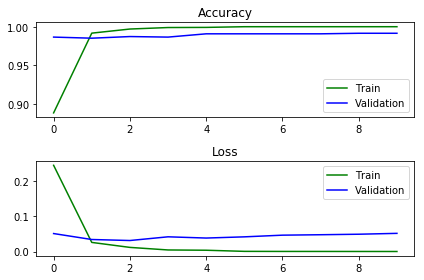

In [34]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color='g', label="Train")
plt.plot(history.history["val_acc"], color='b', label="Validation")
plt.legend()

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color='g', label="Train")
plt.plot(history.history["val_loss"], color='b', label="Validation")
plt.legend()

plt.tight_layout()
plt.show()

## 模型评估

In [35]:
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print("Test score: %.3f, accuracy: %.3f" % (score, acc))

1418/1418 [==============================] - 0s 195us/step
Test score: 0.052, accuracy: 0.992


In [36]:
print("#pred\t#label\tsentence")
for i in range(5):
    idx = np.random.randint(len(Xtest))
    
    xtest = Xtest[idx].reshape(1, MAX_SENTENCE_LENGTH)
    ylabel = ytest[idx]
    
    ypred = model.predict(xtest)[0][0]
    
    sent = " ".join([index2word[x] for x in xtest[0].tolist() if x!=0])
    print("%.0f\t%d\t%s" % (ypred, ylabel, sent))

#pred	#label	sentence
0	0	brokeback mountain is fucking horrible..
0	0	da vinci code the movie sucked .
0	0	oh , and brokeback mountain was a terrible movie .
1	1	i love brokeback mountain ... .
1	1	i love being a sentry for mission impossible and a station for bonkers .
